In [1]:
# Required Libraries
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
# Load the Metadata
metadata_path = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/meta/esc50.csv"
data = pd.read_csv(metadata_path)



In [8]:
# Display basic metadata info
print("Dataset Overview:")
print(data.head())
print("\nDataset Summary:")
print(data.info())

Dataset Overview:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 95.8+ KB
None


In [10]:
# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())





Missing Values:
 filename    0
fold        0
target      0
category    0
esc10       0
src_file    0
take        0
dtype: int64


In [12]:
# Count the number of samples per category
category_counts = data['category'].value_counts()

/var/folders/2r/_pjc413n55l49gnv4rswrjdh0000gn/T/ipykernel_23008/1191629303.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


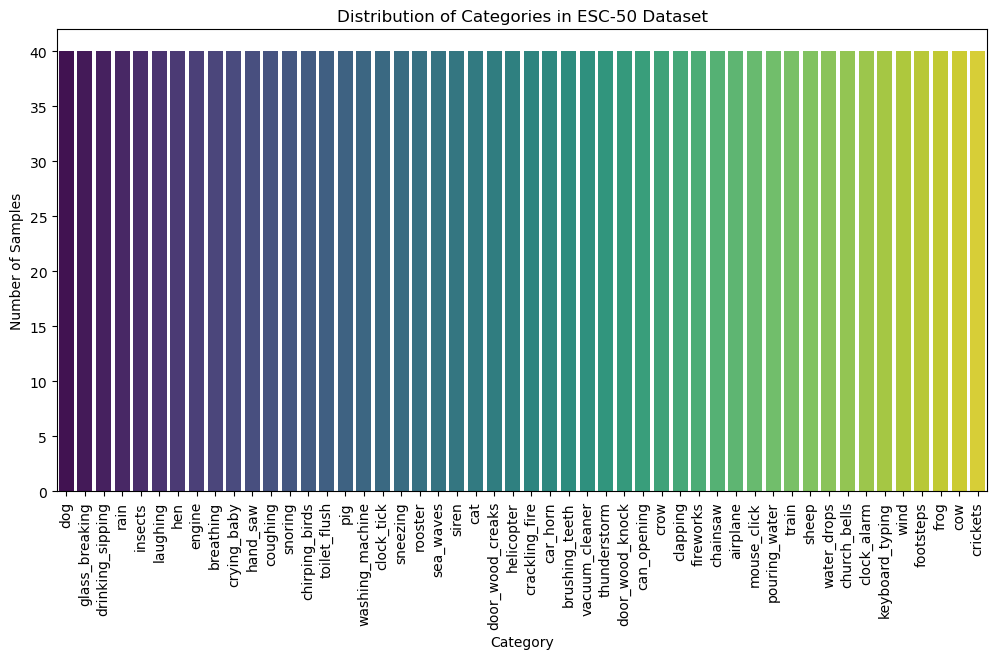

In [14]:
# Plotting the distribution of categories
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Categories in ESC-50 Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Category")
plt.show()





In [16]:
# Audio File Path
audio_dir = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/audio"

# Function to extract features from an audio file
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    rms = librosa.feature.rms(y=y).mean()
    zcr = librosa.feature.zero_crossing_rate(y=y).mean()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    return {"Duration": duration, "RMS": rms, "ZCR": zcr, "Spectral Centroid": spectral_centroid}

In [18]:
# Extract features for a few samples (time-intensive for the full dataset)
sample_files = data.sample(5)  # Analyze 5 random samples
features = []

for _, row in sample_files.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    audio_features = extract_audio_features(file_path)
    audio_features['Category'] = row['category']
    features.append(audio_features)

# Convert to DataFrame for analysis
features_df = pd.DataFrame(features)
print("\nExtracted Features:\n", features_df)


Extracted Features:
    Duration       RMS       ZCR  Spectral Centroid   Category
0       5.0  0.163635  0.082831        3867.914423        cow
1       5.0  0.043224  0.016264         860.500563   car_horn
2       5.0  0.036522  0.010820         506.712860        cat
3       5.0  0.218478  0.045757        1627.789102      siren
4       5.0  0.011929  0.028889        1945.974085  fireworks


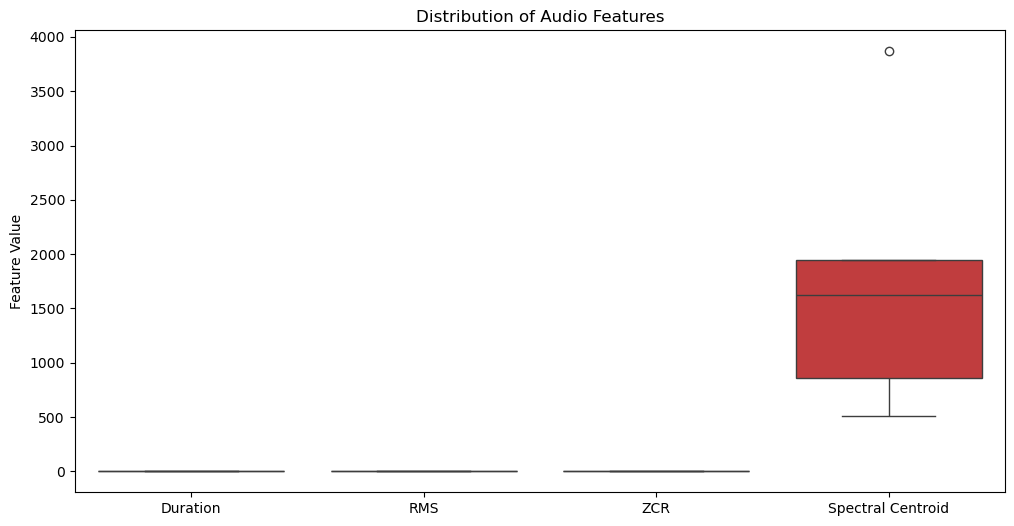

In [20]:

# Visualizing Audio Features
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_df.drop(columns="Category"))
plt.title("Distribution of Audio Features")
plt.ylabel("Feature Value")
plt.show()




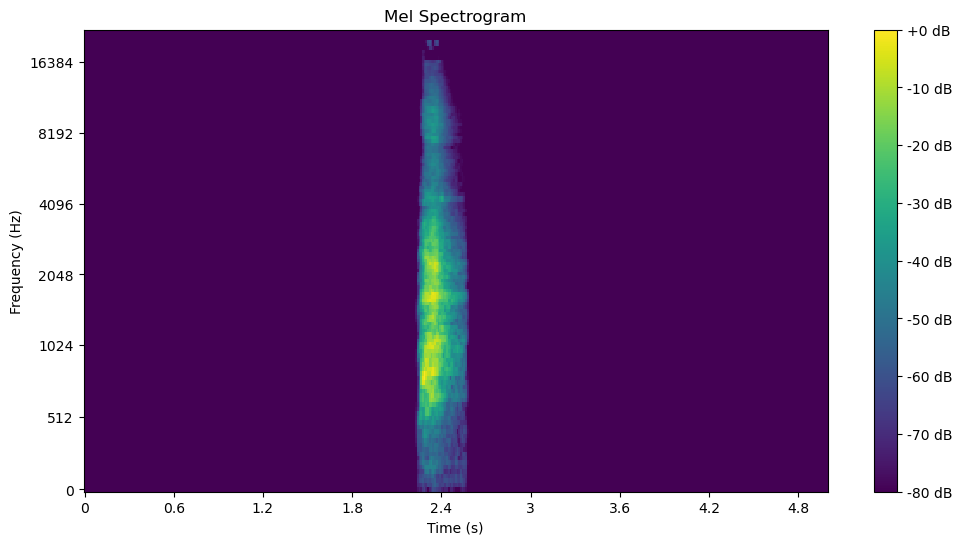

In [22]:
# Example: Visualizing Spectrogram of a Single File
sample_file = os.path.join(audio_dir, data.iloc[0]['filename'])
y, sr = librosa.load(sample_file, sr=None)
plt.figure(figsize=(12, 6))
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# New Section

In [24]:
# Define categories of suspicious sounds
suspicious_categories = ["glass_breaking", "gun_shot", "screaming", "door_knock", "chainsaw"]

# Filter the dataset for suspicious sounds
suspicious_data = data[data['category'].isin(suspicious_categories)]

# Display the filtered dataset
print("Suspicious Sounds Dataset:")
print(suspicious_data)

# Save the filtered dataset to a CSV file (optional)
output_path = "suspicious_sounds.csv"
suspicious_data.to_csv(output_path, index=False)
print(f"Filtered dataset saved to: {output_path}")


Suspicious Sounds Dataset:
               filename  fold  target        category  esc10  src_file take
24    1-116765-A-41.wav     1      41        chainsaw   True    116765    A
92     1-19898-A-41.wav     1      41        chainsaw   True     19898    A
93     1-19898-B-41.wav     1      41        chainsaw   True     19898    B
94     1-19898-C-41.wav     1      41        chainsaw   True     19898    C
95     1-20133-A-39.wav     1      39  glass_breaking  False     20133    A
...                 ...   ...     ...             ...    ...       ...  ...
1880  5-233607-A-39.wav     5      39  glass_breaking  False    233607    A
1971  5-257642-A-39.wav     5      39  glass_breaking  False    257642    A
1979  5-260432-A-39.wav     5      39  glass_breaking  False    260432    A
1980  5-260433-A-39.wav     5      39  glass_breaking  False    260433    A
1981  5-260434-A-39.wav     5      39  glass_breaking  False    260434    A

[80 rows x 7 columns]
Filtered dataset saved to: suspicious_

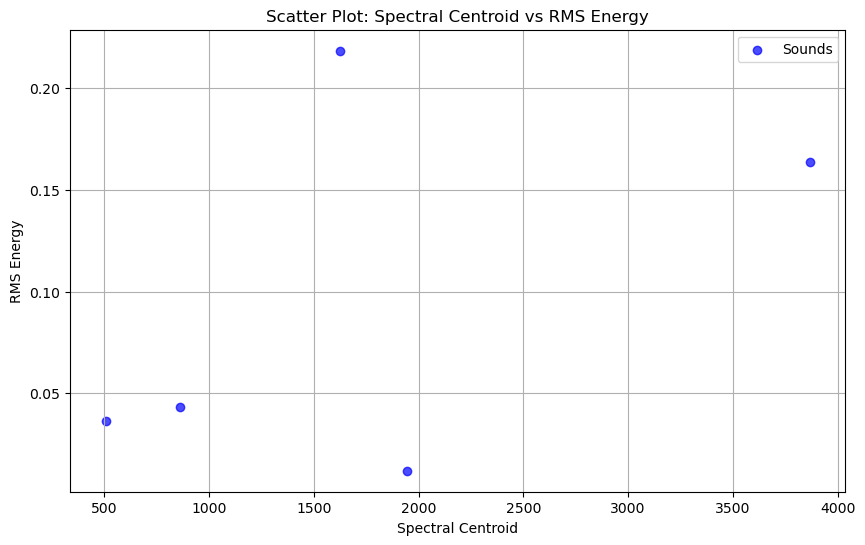

In [26]:


# Scatter Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(features_df['Spectral Centroid'], features_df['RMS'], alpha=0.7, c='blue', label='Sounds')
plt.title("Scatter Plot: Spectral Centroid vs RMS Energy")
plt.xlabel("Spectral Centroid")
plt.ylabel("RMS Energy")
plt.legend()
plt.grid(True)
plt.show()




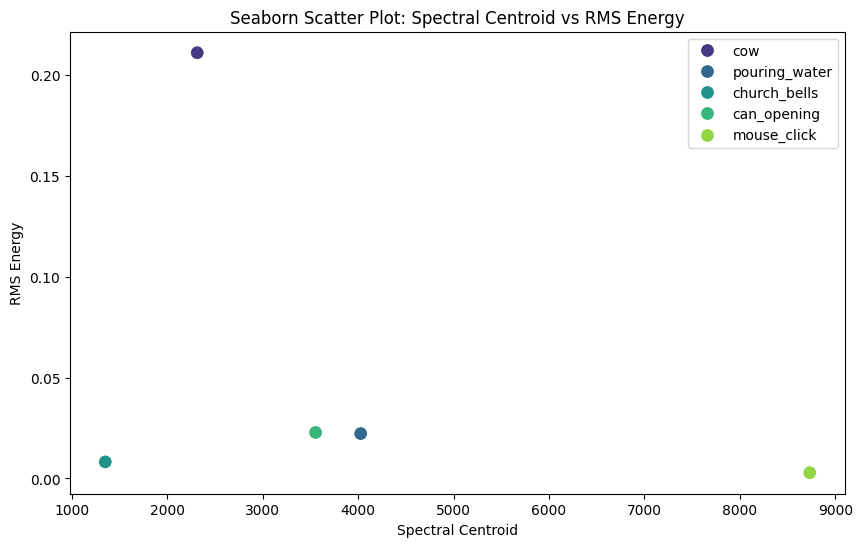

In [14]:
# Scatter Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features_df, x='Spectral Centroid', y='RMS', hue='Category', palette='viridis', s=100)
plt.title("Seaborn Scatter Plot: Spectral Centroid vs RMS Energy")
plt.xlabel("Spectral Centroid")
plt.ylabel("RMS Energy")
plt.legend(loc='upper right')
plt.show()

Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16



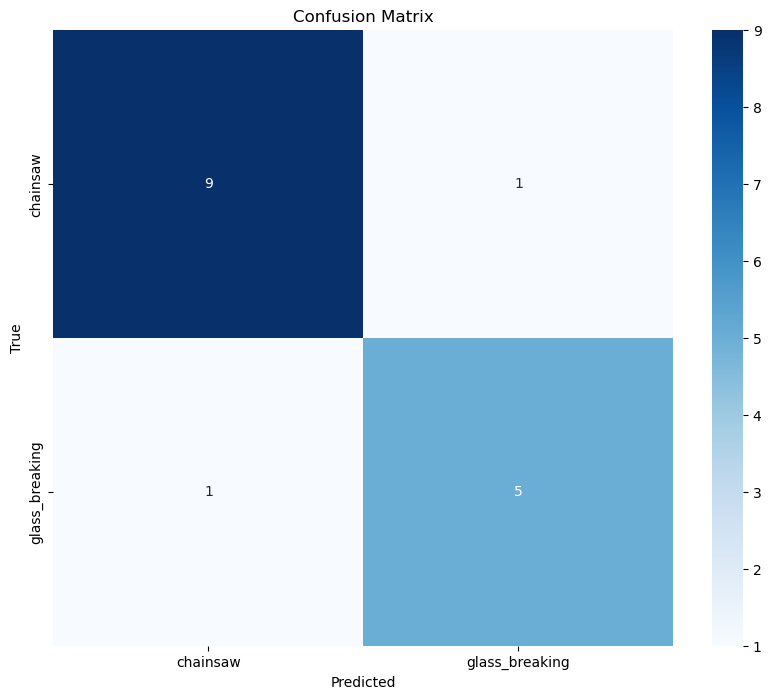

Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16

Accuracy: 87.50%


In [32]:
#applying svm

# Define suspicious categories
suspicious_categories = ["glass_breaking", "gun_shot", "screaming", "door_knock", "chainsaw"]

# Load dataset metadata
metadata_path = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/meta/esc50.csv"
data = pd.read_csv(metadata_path)

# Filter dataset for suspicious sounds
filtered_data = data[data['category'].isin(suspicious_categories)]

# Audio directory path
audio_dir = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/audio"

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {
        "RMS": librosa.feature.rms(y=y).mean(),
        "ZCR": librosa.feature.zero_crossing_rate(y=y).mean(),
        "Spectral Centroid": librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
        "Spectral Bandwidth": librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    }
    return features

# Extract features for the filtered dataset
features = []
labels = []

for _, row in filtered_data.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    audio_features = extract_features(file_path)
    features.append(audio_features)
    labels.append(row['category'])

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df['Label'] = labels

# Prepare feature matrix (X) and target labels (y)
X = features_df.drop(columns="Label")
y = features_df['Label']

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an SVM Classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")





Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.73      0.80      0.76        10
glass_breaking       0.60      0.50      0.55         6

      accuracy                           0.69        16
     macro avg       0.66      0.65      0.65        16
  weighted avg       0.68      0.69      0.68        16



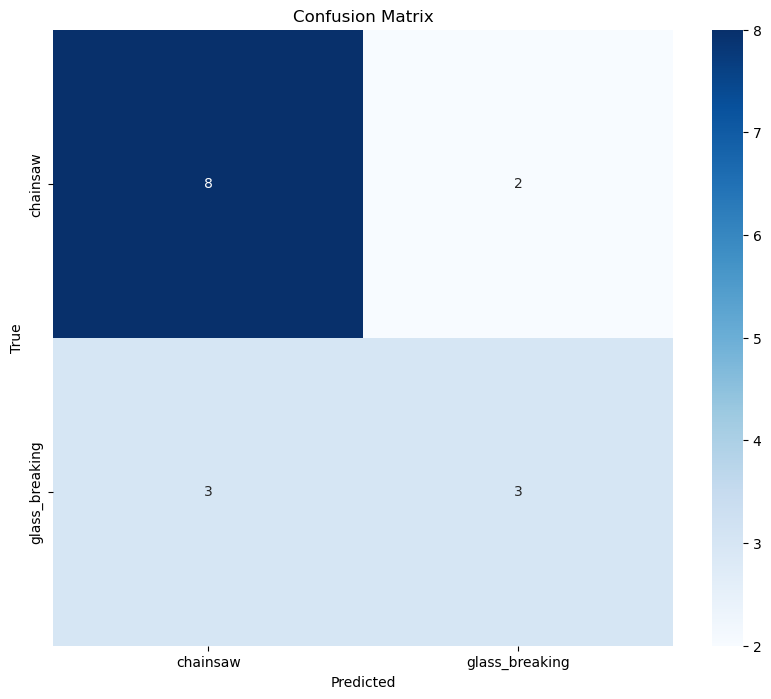

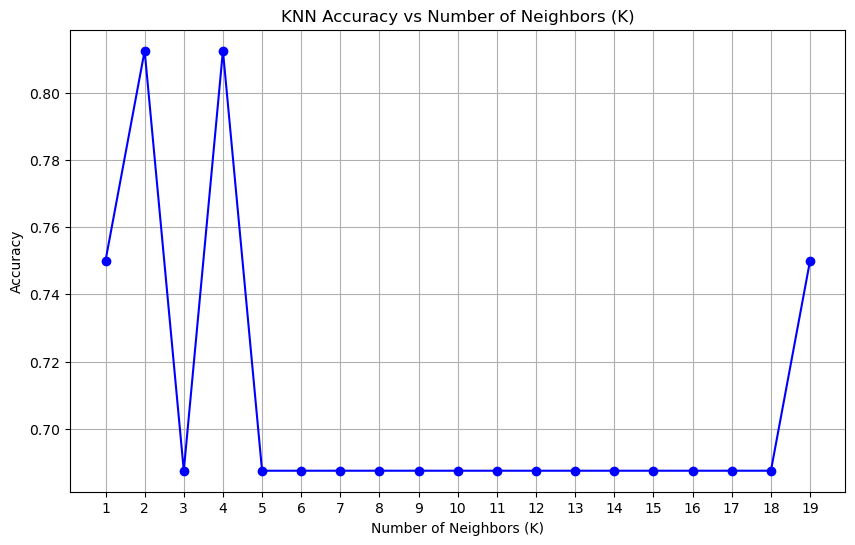

In [34]:
# Applying KNN

# Define suspicious categories
suspicious_categories = ["glass_breaking", "gun_shot", "screaming", "door_knock", "chainsaw"]

# Load dataset metadata
metadata_path = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/meta/esc50.csv"
data = pd.read_csv(metadata_path)

# Filter dataset for suspicious sounds
filtered_data = data[data['category'].isin(suspicious_categories)]

# Audio directory path
audio_dir = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/audio"

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {
        "RMS": librosa.feature.rms(y=y).mean(),
        "ZCR": librosa.feature.zero_crossing_rate(y=y).mean(),
        "Spectral Centroid": librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
        "Spectral Bandwidth": librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    }
    return features

# Extract features for the filtered dataset
features = []
labels = []

for _, row in filtered_data.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    audio_features = extract_features(file_path)
    features.append(audio_features)
    labels.append(row['category'])

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df['Label'] = labels

# Prepare feature matrix (X) and target labels (y)
X = features_df.drop(columns="Label")
y = features_df['Label']

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train KNN Classifier
k = 5  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plotting Accuracy vs K Value (Optional)
accuracy_list = []
for k in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    accuracy = knn_model.score(X_test, y_test)
    accuracy_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), accuracy_list, marker='o', linestyle='-', color='blue')
plt.title("KNN Accuracy vs Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.xticks(range(1, 20))
plt.grid()
plt.show()




Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16

Accuracy: 87.50%


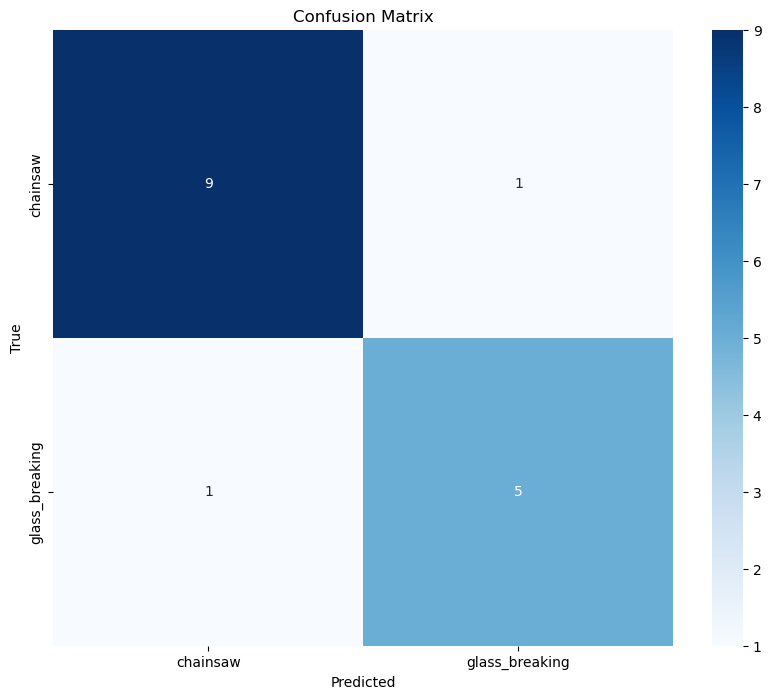

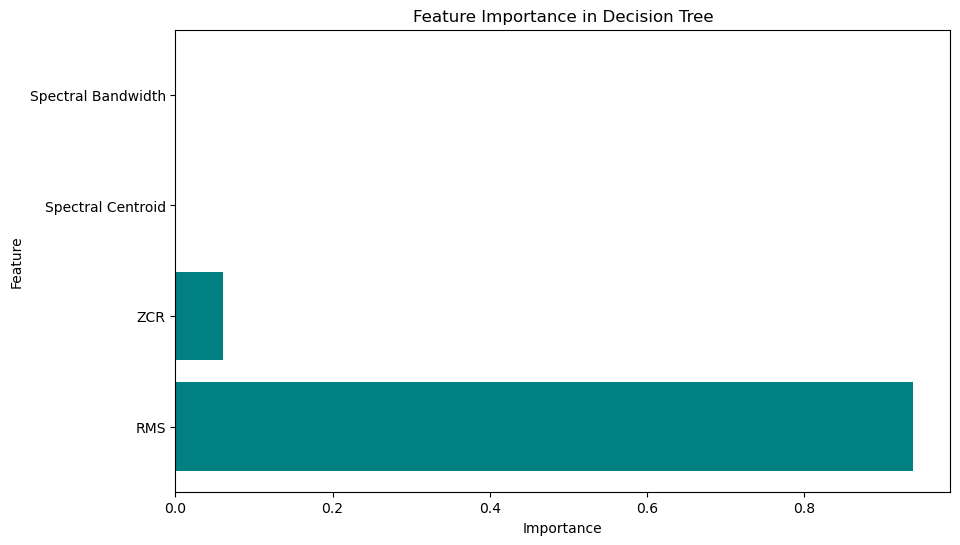

In [36]:
# Decision Tree

# Prepare the feature matrix (X) and target labels (y)
# Assuming 'X' (features) and 'y' (labels) are already prepared as shown in earlier steps.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # Adjust max_depth if necessary
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Feature Importance
importances = dt_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances, color='teal')
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16

Accuracy: 87.50%


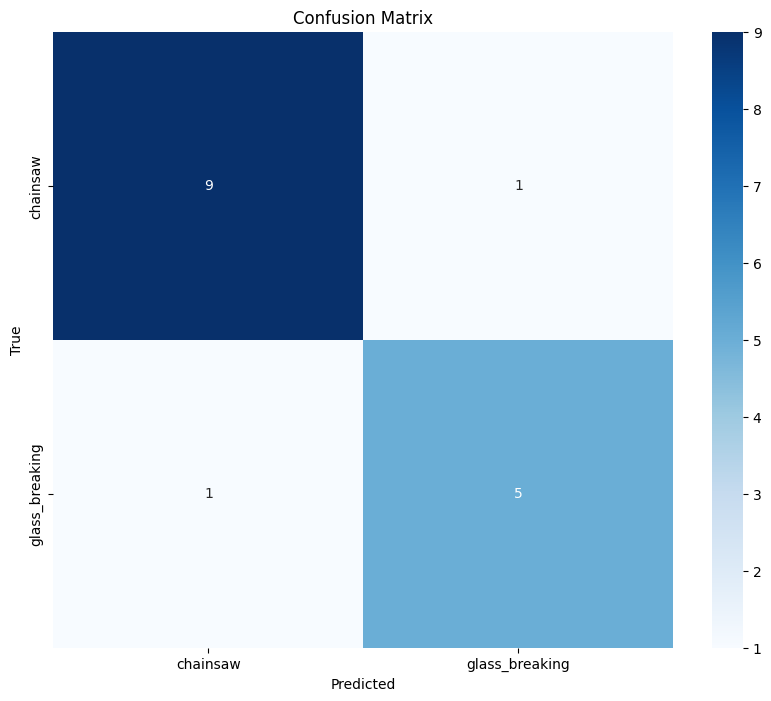

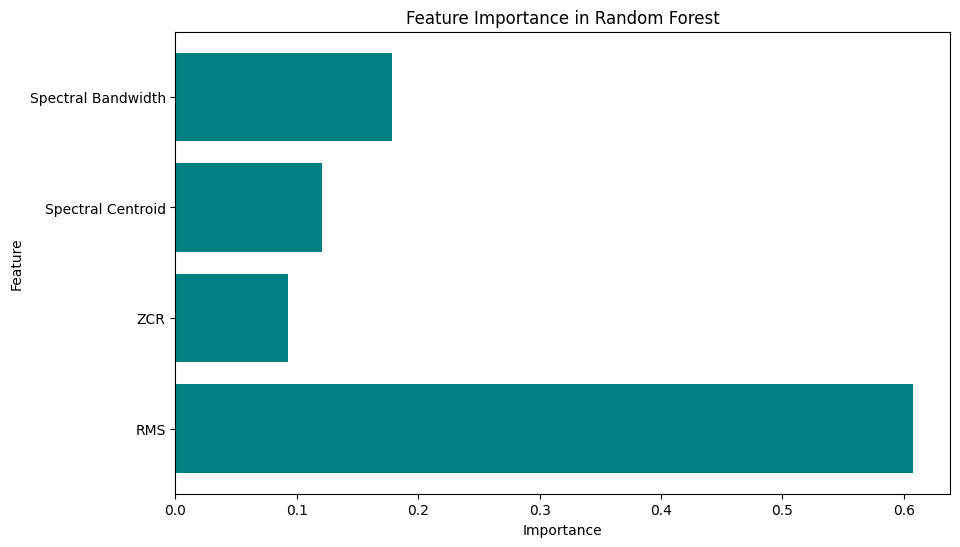

In [18]:
# RandomForestClassifier

# Prepare the feature matrix (X) and target labels (y)
# Assuming 'X' (features) and 'y' (labels) are already prepared as shown in earlier steps.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Number of trees set to 100
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances, color='teal')
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4754 - loss: 1.0638 - val_accuracy: 0.6979 - val_loss: 0.6599
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7911 - loss: 0.4344 - val_accuracy: 0.9167 - val_loss: 0.2629
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9504 - loss: 0.1633 - val_accuracy: 0.9479 - val_loss: 0.1317
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9769 - loss: 0.0828 - val_accuracy: 0.9792 - val_loss: 0.0734
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9838 - loss: 0.0571 - val_accuracy: 0.9688 - val_loss: 0.0986
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9527 - loss: 0.1364 - val_accuracy: 0.9479 - val_loss: 0.1298
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9792 - loss: 0.0699 - val_accuracy: 0.9896 - val_loss: 0.0430
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9894 - loss: 0.0273 - val_accuracy: 0.9792 - val_l

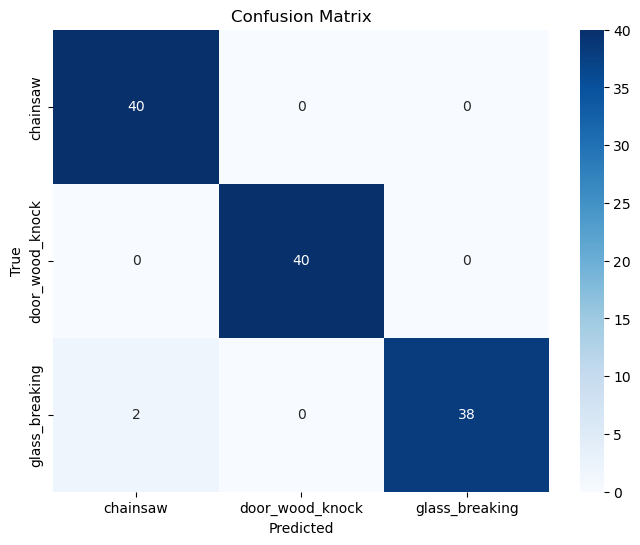

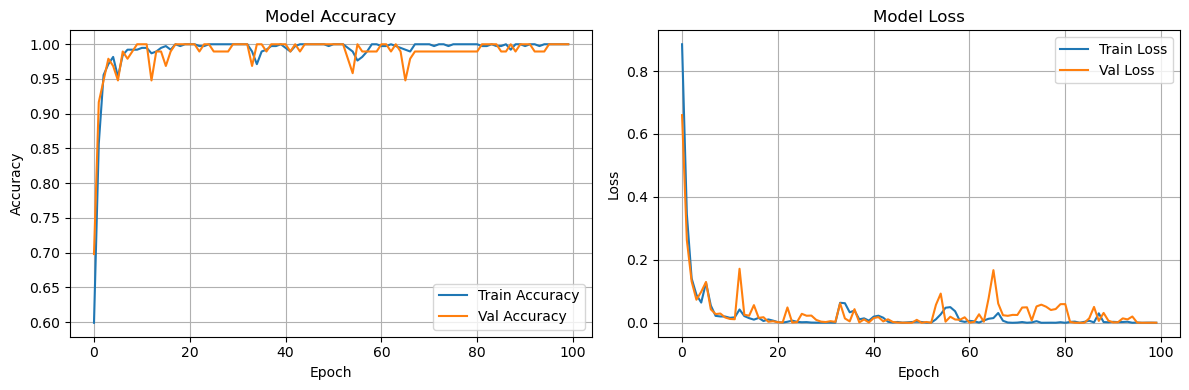

In [58]:
 # DEEP LEARNING FOR 3-CLASS AUDIO CLASSIFICATION WITH AUGMENTATION 

# STEP 1: Import Libraries
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# STEP 2: Define Target Categories
suspicious_categories = ["glass_breaking", "chainsaw", "door_wood_knock"]

# STEP 3: Load Metadata
metadata_path = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/meta/esc50.csv"   
audio_dir = "/Users/kalyanivaidya/Downloads/Detection-of-Unusual-Activity-in-Surveillance-Video-Scenes-Based-on-Deep-Learning-Strategies--main/ESC-50-master/audio"            
data = pd.read_csv(metadata_path)

filtered_data = data[data['category'].isin(suspicious_categories)]

# STEP 4: Define Augmentation + Feature Extraction
def augment_audio(y, sr):
    return [
        y,
        librosa.effects.time_stretch(y, rate=0.9),
        librosa.effects.time_stretch(y, rate=1.1),
        librosa.effects.pitch_shift(y, sr=sr, n_steps=2),
        librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
    ]

def audio_to_melspectrogram(y, sr, max_len=128):
    mels = librosa.feature.melspectrogram(y=y, sr=sr)
    mels_db = librosa.power_to_db(mels, ref=np.max)
    if mels_db.shape[1] < max_len:
        mels_db = np.pad(mels_db, ((0, 0), (0, max_len - mels_db.shape[1])), mode='constant')
    else:
        mels_db = mels_db[:, :max_len]
    return cv2.resize(mels_db, (128, 128))

# STEP 5: Build Dataset
X, y = [], []

for _, row in filtered_data.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    try:
        y_audio, sr = librosa.load(file_path, sr=22050)
        variants = augment_audio(y_audio, sr)
        for v in variants:
            spec = audio_to_melspectrogram(v, sr)
            X.append(spec)
            y.append(row['category'])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

X = np.array(X)[..., np.newaxis] / 255.0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# STEP 6: Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42)

# STEP 7: Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# STEP 8: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

# STEP 9: Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

# STEP 10: Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# STEP 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# STEP 12: Accuracy & Loss Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# STEP 1: Reshape Spectrograms (remove last channel)
X_train_gru = X_train.squeeze()  # (samples, 128, 128)
X_test_gru = X_test.squeeze()

# STEP 2: Define Bidirectional GRU Model
model_input = Input(shape=(128, 128))  # time_steps, features

x = Bidirectional(GRU(128, return_sequences=True))(model_input)
x = Dropout(0.3)(x)
x = Bidirectional(GRU(64))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(y_train_cat.shape[1], activation='softmax')(x)

bi_gru_model = Model(inputs=model_input, outputs=output)

# STEP 3: Compile
bi_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# STEP 4: Train
bi_gru_model.fit(X_train_gru, y_train_cat, epochs=10, batch_size=16, validation_split=0.2, verbose=1)

# STEP 5: Evaluate
loss, acc = bi_gru_model.evaluate(X_test_gru, y_test_cat, verbose=0)
print(f"Bidirectional GRU Test Accuracy: {acc * 100:.2f}%")

# Optional: Add to results list
results.append({"Model": "Bidirectional GRU", "Accuracy": acc * 100})


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.3737 - loss: 1.0872 - val_accuracy: 0.7500 - val_loss: 0.8508
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7015 - loss: 0.7364 - val_accuracy: 0.7083 - val_loss: 0.6434
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8856 - loss: 0.3519 - val_accuracy: 0.7292 - val_loss: 0.6807
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8761 - loss: 0.3702 - val_accuracy: 0.8854 - val_loss: 0.3078
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9269 - loss: 0.2260 - val_accuracy: 0.8229 - val_loss: 0.3849
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9425 - loss: 0.1652 - val_accuracy: 0.8438 - val_loss: 0.4543
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9464 - loss: 0.1397 - val_accuracy: 0.8646 - val_loss: 0.3964
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9587 - loss: 0.1776 - val_accuracy: 0.9479


 Bidirectional GRU Test Accuracy: 96.67%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step

 Classification Report:
                 precision    recall  f1-score   support

       chainsaw       0.93      0.97      0.95        40
door_wood_knock       1.00      0.97      0.99        40
 glass_breaking       0.97      0.95      0.96        40

       accuracy                           0.97       120
      macro avg       0.97      0.97      0.97       120
   weighted avg       0.97      0.97      0.97       120



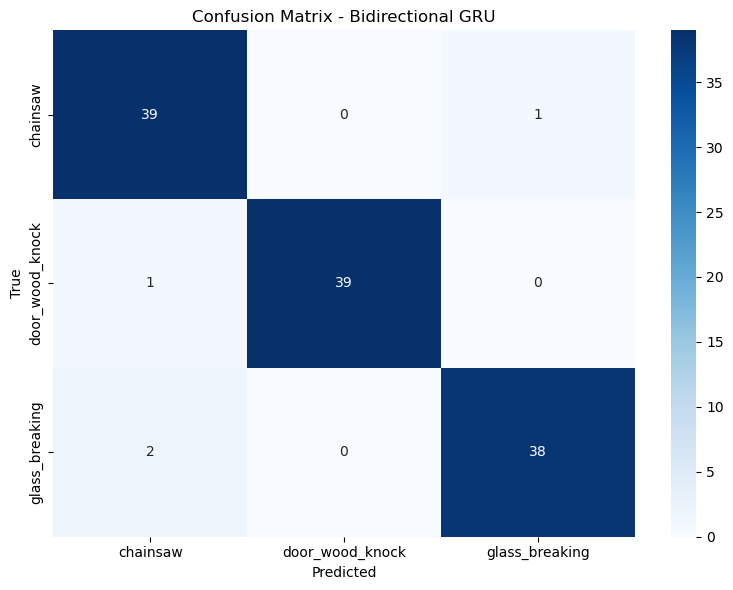

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate Accuracy and Loss
loss, acc = bi_gru_model.evaluate(X_test_gru, y_test_cat, verbose=0)
print(f"\n Bidirectional GRU Test Accuracy: {acc * 100:.2f}%")

# Get Predictions 
y_pred_probs = bi_gru_model.predict(X_test_gru)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report 
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Bidirectional GRU")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Add to Model Comparison
results.append({"Model": "Bidirectional GRU", "Accuracy": acc * 100})


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Comparison Results:
                 Model   Accuracy
3        Decision Tree  89.166667
1    Bidirectional GRU  95.833331
2        Random Forest  95.833333
4                  KNN  97.500000
0  CNN (Deep Learning)  99.166667


/var/folders/2r/_pjc413n55l49gnv4rswrjdh0000gn/T/ipykernel_23008/1547387830.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x="Accuracy", y="Model", data=results_df, palette="coolwarm")
/var/folders/2r/_pjc413n55l49gnv4rswrjdh0000gn/T/ipykernel_23008/1547387830.py:89: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


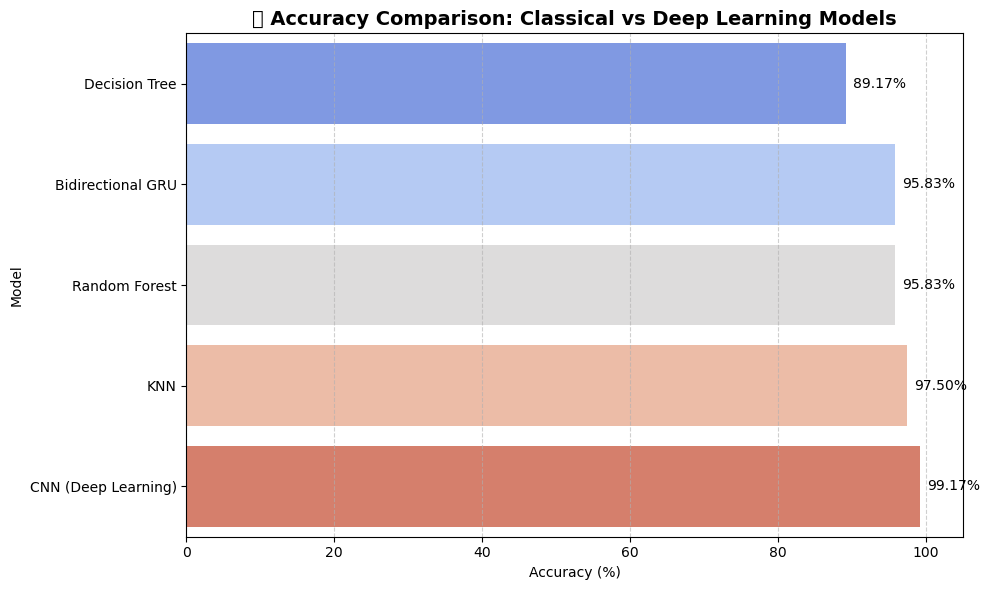

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GRU, Bidirectional, Input
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep 
# Assume X and y_encoded already prepared and scaled properly
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

results = []

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_train_cat.shape[1], activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=16, verbose=0)
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
results.append({"Model": "CNN (Deep Learning)", "Accuracy": cnn_acc * 100})

# Bidirectional GRU Model
X_train_gru = X_train.squeeze()  # (samples, 128, 128)
X_test_gru = X_test.squeeze()

gru_input = Input(shape=(128, 128))
x = Bidirectional(GRU(128, return_sequences=True))(gru_input)
x = Dropout(0.3)(x)
x = Bidirectional(GRU(64))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
gru_output = Dense(y_train_cat.shape[1], activation='softmax')(x)
bi_gru_model = Model(inputs=gru_input, outputs=gru_output)

bi_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bi_gru_model.fit(X_train_gru, y_train_cat, epochs=10, batch_size=16, verbose=0)
gru_loss, gru_acc = bi_gru_model.evaluate(X_test_gru, y_test_cat, verbose=0)
results.append({"Model": "Bidirectional GRU", "Accuracy": gru_acc * 100})

# Classical ML Models
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

for name, clf in classifiers.items():
    clf.fit(X_train.reshape(len(X_train), -1), y_train)  # Flatten for classical ML
    y_pred = clf.predict(X_test.reshape(len(X_test), -1))
    accuracy = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": accuracy * 100})

# Display Results
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=True)
print("Model Comparison Results:")
print(results_df)

# Better Graph: Horizontal Grouped Bar Chart 
plt.figure(figsize=(10, 6))
bars = sns.barplot(x="Accuracy", y="Model", data=results_df, palette="coolwarm")

# Add value labels to bars
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}%', va='center')

# Styling
plt.title("📊 Accuracy Comparison: Classical vs Deep Learning Models", fontsize=14, weight='bold')
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.xlim(0, 105)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
